## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [83]:
import numpy as np
!pip install tensorflow==2.12.0
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,Dropout
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from collections import Counter


from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**QUESTION:** Load dataset and display some lines of the csv file.

In [84]:

# Load CSV into DataFrame
df = pd.read_csv(file_path)

# Display first 5 rows
df.head()

# z
df.iloc[[10,2,3,4]]


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
10,11,H29424,H,298.4,308.9,1782,23.9,24,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

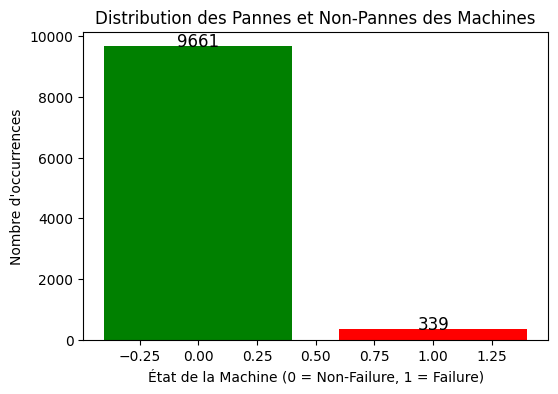

In [85]:
# Compter les échecs et non-échecs
failure_counts = df["Machine failure"].value_counts()

# Création du graphique
plt.figure(figsize=(6, 4))
plt.bar(failure_counts.index, failure_counts.values, color=['green', 'red'])

# Ajout de labels et titre
plt.xlabel("État de la Machine (0 = Non-Failure, 1 = Failure)")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des Pannes et Non-Pannes des Machines")

# Ajout des valeurs sur les barres
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

# Affichage du graphique
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On a une proportion de machine qui est tombé en panne très faible, de l'ordre de 3.39%.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

On a une classe qui est bien plus majoritaire que l'autre, cela peut alors fausser notre modèle. Biais vers la classe majoritaire, cela pourrait créer une mauvaise détection des pannes. On pourrait aussi obtenir une accuracy fausse.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

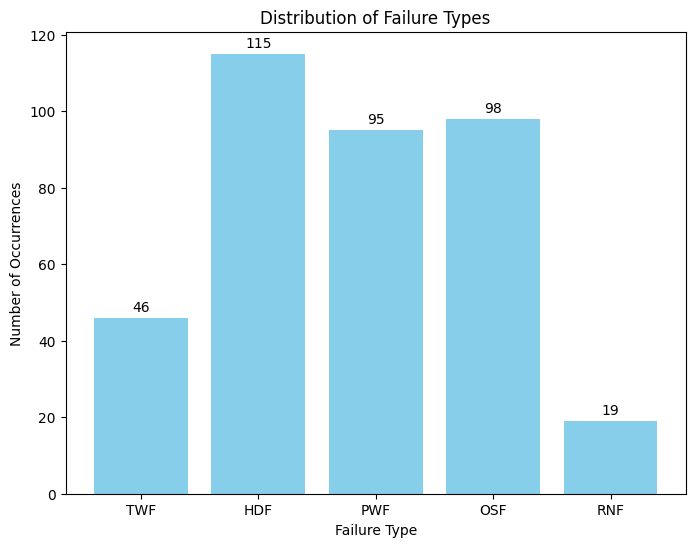

In [86]:
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

failure_counts = {failure: df[failure].sum() for failure in failure_types}

plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='skyblue')
plt.xlabel("Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Failure Types")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Premièrement, le total est supérieur à 339 qui est notre nombre total de machine, cela implique qu'il y a des machines en pannes à cause de deux erreurs différentes ou plus. Deuxièmement, on voit l'importance de certaines erreurs comparé à d'autre.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

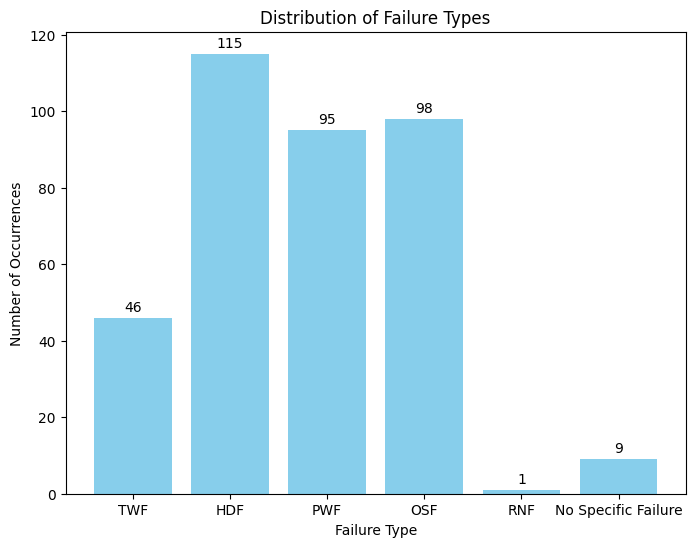

In [87]:
df_failure = df[df["Machine failure"] == 1]

failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]

failure_counts = {failure: df_failure[failure].sum() for failure in failure_types}

failure_counts["No Specific Failure"] = ((df_failure[failure_types] == 0).all(axis=1)).sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='skyblue')
plt.xlabel("Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Failure Types")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Comparé à la question d'avant, cette fois on regarde parmis les machines qui ont été en panne. On retrouve donc que 18 machines ont des "RNF" sans être en panne pour autant de plus donc des erreurs mineures. Il y a 9 erreurs qui ne sont pas spécifiés, c'est minoritaire par rapport aux autres erreurs.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [88]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Pour les entrées on prendra les colonnes : Type, Air temperatur, Process temperature, Rotational speed, Torque, Tool Wear.
Pour les sorties, on prendra les colonnes : Machine failure, TWF, HDF, PWF, OSF, RNF.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [89]:
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['TWF', 'HDF', 'PWF', 'OSF']]
no_error_condition = (Y[['TWF', 'HDF', 'PWF', 'OSF']] == 0).all(axis=1)

# Ajouter une colonne "No Error" dans Y, avec la valeur "No Error" pour les machines sans erreur
Y['Error Class'] = np.where(no_error_condition, 'No Error', Y.idxmax(axis=1))
# Diviser les données en ensembles d'entraînement et de test

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y['Error Class'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"X_train: {len(X_train)}")
print(f"Y_train: {len(Y_train)}")
print(f"X_test: {len(X_test)}")
print(f"Y_test: {len(Y_test)}")


X_train: 8000
Y_train: 8000
X_test: 2000
Y_test: 2000


<ipython-input-89-a35d19ed3f26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Error Class'] = np.where(no_error_condition, 'No Error', Y.idxmax(axis=1))


**QUESTION** Code below the model architecture

In [90]:

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.05),
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])




**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

In [91]:
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
Y_train = to_categorical(Y_train, num_classes=5)  # Assuming 5 classes
Y_test = to_categorical(Y_test, num_classes=5)
history = model.fit(X_train, Y_train, epochs=20, batch_size=300, validation_data=(X_test, Y_test))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                384       
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 6,789
Trainable params: 6,789
Non-train

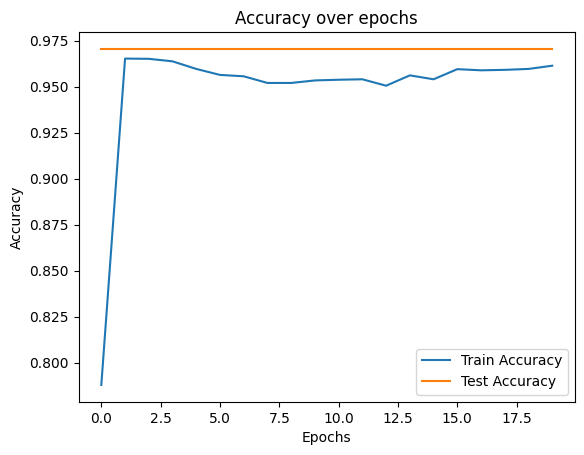

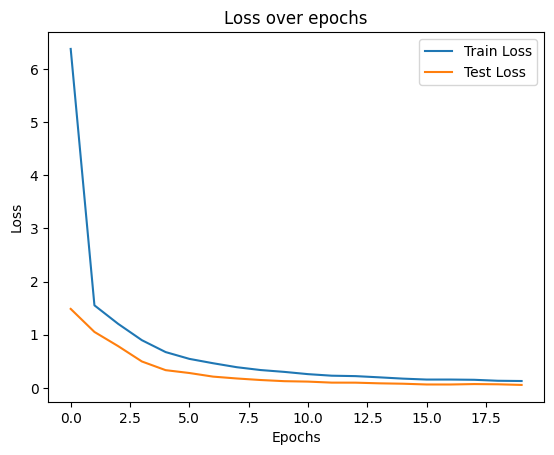

In [92]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 [==============================] - 0s 2ms/step

Matrice de confusion pour la classe 0:
[[1983    0]
 [  17    0]]


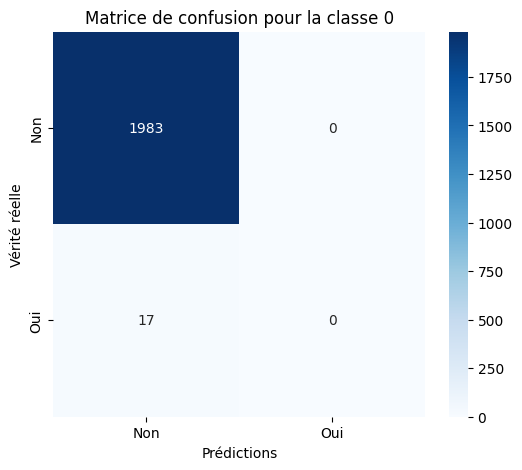


Matrice de confusion pour la classe 1:
[[   0   59]
 [   0 1941]]


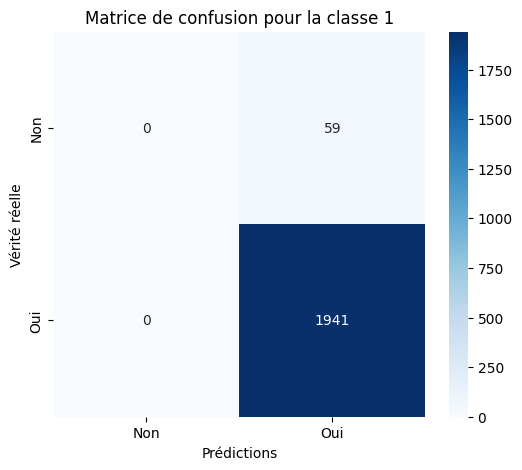


Matrice de confusion pour la classe 2:
[[1987    0]
 [  13    0]]


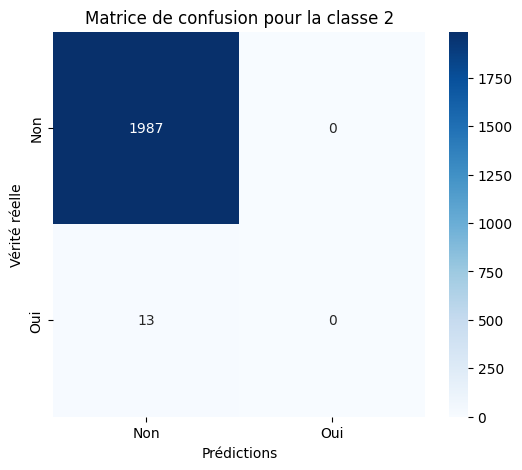


Matrice de confusion pour la classe 3:
[[1982    0]
 [  18    0]]


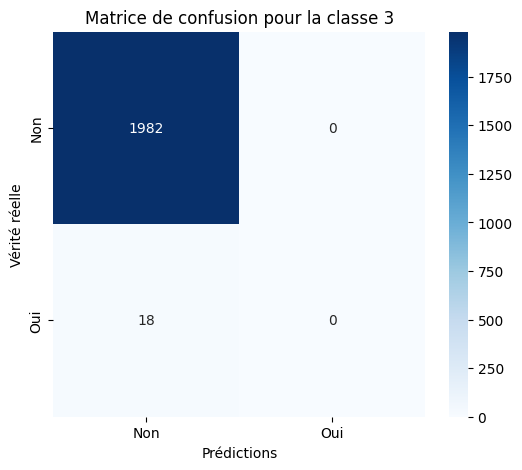


Matrice de confusion pour la classe 4:
[[1989    0]
 [  11    0]]


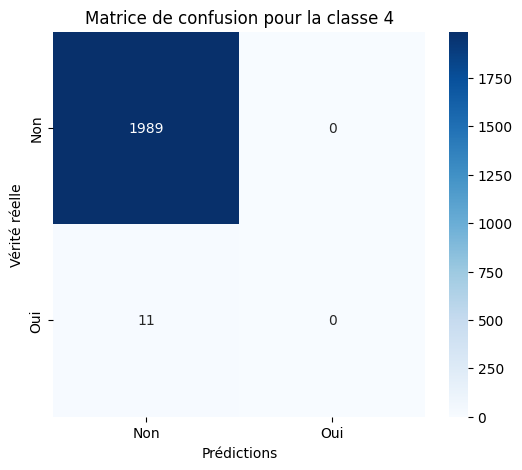


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.97      1.00      0.99      1941
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        11

   micro avg       0.97      0.97      0.97      2000
   macro avg       0.19      0.20      0.20      2000
weighted avg       0.94      0.97      0.96      2000
 samples avg       0.97      0.97      0.97      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Prédictions du modèle
y_pred = model.predict(X_test)

# Définir un seuil pour prédire 1 ou 0 (par exemple, seuil de 0.5)
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)

# Calculer la matrice de confusion multilabel
mcm = multilabel_confusion_matrix(Y_test, y_pred_classes)

# Affichage de la matrice de confusion
# mcm[i] est la matrice de confusion pour la classe i
num_classes = mcm.shape[0]

# Afficher chaque matrice de confusion pour chaque étiquette
for i in range(num_classes):
    print(f"\nMatrice de confusion pour la classe {i}:")
    print(mcm[i])

    # Afficher une matrice de confusion sous forme de graphique
    plt.figure(figsize=(6, 5))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    plt.title(f'Matrice de confusion pour la classe {i}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vérité réelle')
    plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred_classes))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [94]:
X_train, X_test_1, Y_train, Y_test_1 = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)
#SMOTE
smote = SMOTE(random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train,Y_train)
print("Distribution après SMOTE :", Counter(Y_train_res))
target_count = min(Counter(Y_train_res).values())
undersample_strategy = {label: target_count for label in set(Y_train_res)}

# Undersampling
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_over, Y_train_over = undersample.fit_resample(X_train_res, Y_train_res)

# Affichage des tailles
print(f"X_train_over: {len(X_train_over)}")
print(f"Y_train_over: {len(Y_train_over)}")
print("Distribution après undersampling :", Counter(Y_train_over))

Distribution après SMOTE : Counter({1: 7729, 3: 7729, 0: 7729, 4: 7729, 2: 7729})
X_train_over: 38645
Y_train_over: 38645
Distribution après undersampling : Counter({0: 7729, 1: 7729, 2: 7729, 3: 7729, 4: 7729})


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [95]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.05),
    Dense(64, activation='tanh'),
    Dropout(0.05),
    Dense(64, activation='tanh'),
    Dropout(0.05),
    Dense(5, activation='softmax')
])

**QUESTION** Code below the algorithms allowing to train model


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                384       
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 5)               

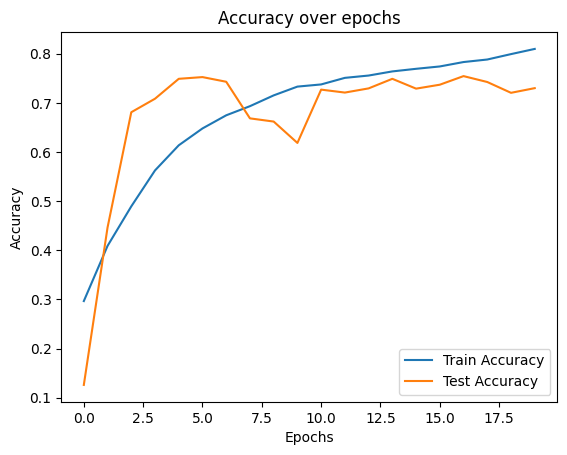

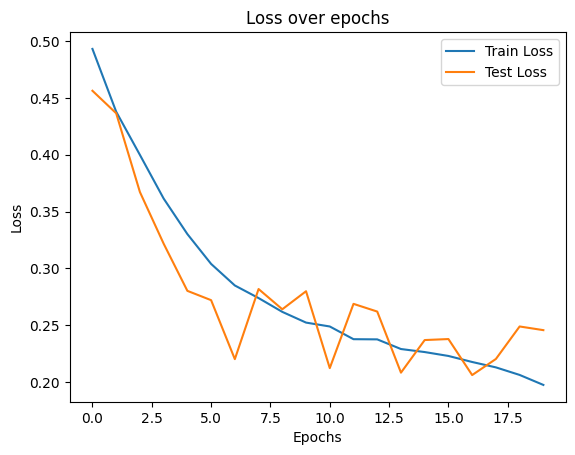

7/7 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.7300


In [96]:

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
Y_train_over = to_categorical(Y_train_over, num_classes=5)  # Assuming 5 classes
history = model.fit(X_train_over, Y_train_over, epochs=20, batch_size=300, validation_data=(X_test, Y_test))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = model.evaluate(X_train_over, Y_train_over, batch_size=300)
loss_test, acc_test = model.evaluate(X_test, Y_test, batch_size=300)

**QUESTION** Plot the confusion matrix and the classification report

63/63 [==============================] - 0s 2ms/step

Matrice de confusion pour la classe 0:
[[1777  206]
 [   8    9]]


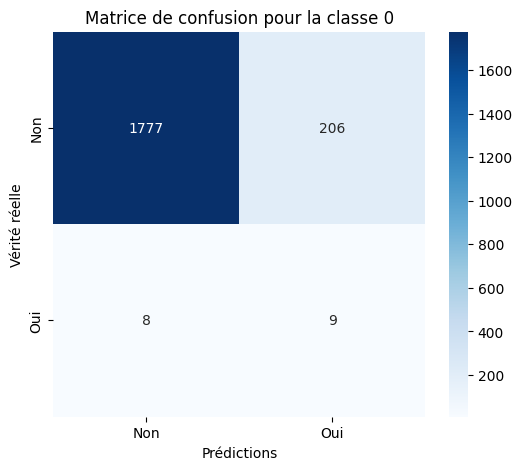


Matrice de confusion pour la classe 1:
[[  57    2]
 [ 536 1405]]


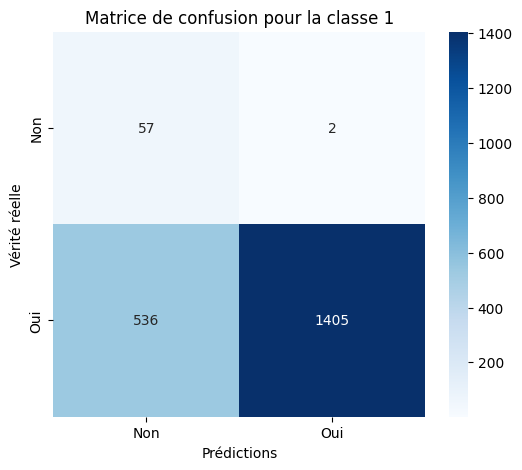


Matrice de confusion pour la classe 2:
[[1946   41]
 [   1   12]]


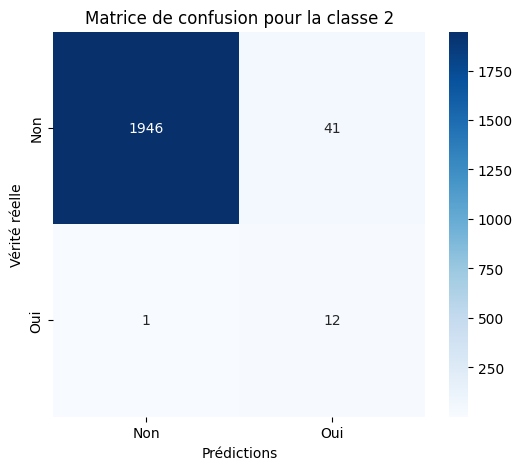


Matrice de confusion pour la classe 3:
[[1913   69]
 [   3   15]]


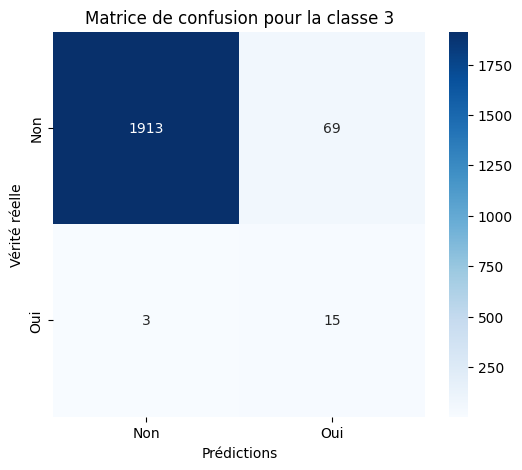


Matrice de confusion pour la classe 4:
[[1786  203]
 [   2    9]]


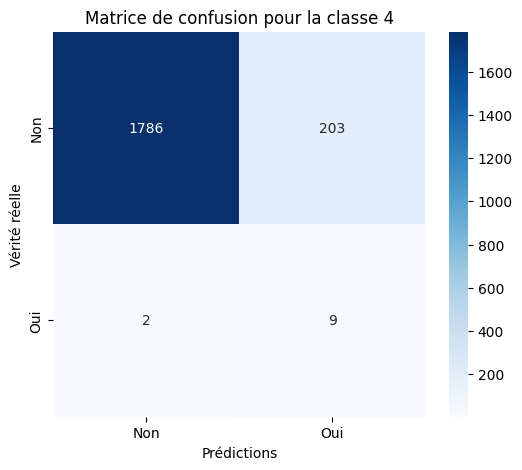


Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.53      0.08        17
           1       1.00      0.72      0.84      1941
           2       0.23      0.92      0.36        13
           3       0.18      0.83      0.29        18
           4       0.04      0.82      0.08        11

   micro avg       0.74      0.72      0.73      2000
   macro avg       0.30      0.77      0.33      2000
weighted avg       0.97      0.72      0.82      2000
 samples avg       0.72      0.72      0.72      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
# Prédictions du modèle
y_pred = model.predict(X_test)

# Définir un seuil pour prédire 1 ou 0 (par exemple, seuil de 0.5)
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)

# Calculer la matrice de confusion multilabel
mcm = multilabel_confusion_matrix(Y_test, y_pred_classes)

# Affichage de la matrice de confusion
# mcm[i] est la matrice de confusion pour la classe i
num_classes = mcm.shape[0]

# Afficher chaque matrice de confusion pour chaque étiquette
for i in range(num_classes):
    print(f"\nMatrice de confusion pour la classe {i}:")
    print(mcm[i])

    # Afficher une matrice de confusion sous forme de graphique
    plt.figure(figsize=(6, 5))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    plt.title(f'Matrice de confusion pour la classe {i}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vérité réelle')
    plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred_classes))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On remarque qu'on a une moins bonne accuracy que sans le balancement mais certaines de nos matrices de confusion sont devenues un peu plus cohérentes. On remarque que notre modèle s'est adapté et ne considère pas que toutes les machines sont défectueuses ou non, on a une variation dans les choix du modèle.


In [98]:
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)
model.save("Model_V1.h5")